In [4]:
import requests
import json
import prettytable
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import datetime
from IPython.display import Image
from functools import reduce


### Project 2 topic: 

#### The Federal Reserve's mandate from Congress is to control inflation and to maintain low unemployment. These seem to be contradictory objectives.

For this story you will need to source the following data for the last 25 years;

The Consumer Price Index (CPI) (Bureau of Labor Statistics)

The FED Funds Rate (FRED) (Federal Reserve Board)

Unemployment Rate  (Bureau of Labor Statistics)
Your Data Visualizations should be designed to answer the question "Has the FED been able to fulfill the mandate given to it by Congress?"

### API requests to retrieve data from BLS
System only allows API retrieval up to 10 years of data.

#### To obtain the **CPI** and the **unemployment rate** from 1999-2024
#### We can split the API requests into 3 requests through a loop:

In [5]:
headers = {'Content-type': 'application/json'}
year_ranges = [(1998, 2008), (2009, 2018), (2019, 2024)]
series_ids = ['CUUR0000SA0L1E', 'LNS14000000']

all_data = []

for i, (start, end) in enumerate(year_ranges, start=1):
    data = json.dumps({
        'seriesid': series_ids,
        'startyear': str(start),
        'endyear': str(end)
    })

    #requests:
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = p.json()
    
    for series in json_data['Results']['series']:
        seriesId = series['seriesID']
        for item in series['data']:
            year = item['year']
            period = item['period']
            value = item['value']
            footnotes= ",".join(
                [f['text'] for f in item['footnotes'] if f]
            )
            if 'M01' <= period <= 'M12':
                all_data.append({
                    'series_id': seriesId,
                    'year': year,
                    'period': period,
                    'value': value,
                    'footnotes': footnotes
                })

#Convert to pandas:
df = pd.DataFrame(all_data)

df.to_csv('bls.csv', index = False)
   

### To obtain the FRED rate through the API:

In [6]:
import requests
import pandas as pd
key = 'ffe6dec1e433657d45d1cdd6362aa518'

url = 'https://api.stlouisfed.org/fred/series/observations?'

params = {
    'series_id': 'FEDFUNDS',
    'file_type': 'json',
    'api_key': key,
    'observation_start': '1998-01-01',
    'observation_end': '2024-12-01',
    'frequency': 'm'
}

response = requests.get(url, params=params)
data = response.json()

#Import to pandas dataframe:
FED_df = pd.DataFrame(data['observations'])
FED_df = FED_df[['date', 'value']]
FED_df.rename(columns={'value': 'FED_rate'}, inplace=True)
FED_df.head()

,date,FED_rate
0,1998-01-01,5.56
1,1998-02-01,5.51
2,1998-03-01,5.49
3,1998-04-01,5.45
4,1998-05-01,5.49


### Data cleanings:

In [7]:
#To separate the CPI data from the unemployment data:
df_cpi = df[df['series_id'].str.startswith('CUU')]

df_unemply = df[df['series_id'].str.startswith('LNS')]

#Convert the months into months only:
df_cpi = df_cpi[['year', 'period', 'value']]
df_unemply = df_unemply[['year', 'period', 'value']]

#Rename columns:
df_cpi.rename(columns={'value':'cpi', 'period':'month'}, inplace = True)
df_unemply.rename(columns={'value':'unemply_rate', 'period':'month'}, inplace = True)

#Remove the 'M' in the month column:
df_cpi['month'] = df_cpi['month'].str.replace('M', '')
df_unemply['month'] = df_unemply['month'].str.replace('M', '')

#Add a day column then combine and convert the date column:
df_cpi['day'] = 1
df_unemply['day'] = 1

df_cpi['date'] = pd.to_datetime(df_cpi[['year', 'month', 'day']])
df_unemply['date'] =  pd.to_datetime(df_unemply[['year', 'month', 'day']])

df_cpi = df_cpi[['date', 'cpi']]
df_unemply = df_unemply[['date', 'unemply_rate']]

#use only the date and value columns and format the date column into date format:
FED_df['date'] = pd.to_datetime(FED_df['date'])
FED_df.set_index('date', inplace=True)

#Covert rate column to float:
FED_df['FED_rate'] = pd.to_numeric(FED_df['FED_rate'], errors = 'coerce')

#Merge the three files into a tidy format:
dfs = [df_cpi, df_unemply, FED_df]
df_final = reduce(lambda left, right: pd.merge(left, right, on='date'), dfs)

#Set index as date:
df_final = df_final.sort_values(by = 'date')
df_final['cpi'] = df_final['cpi'].astype('float')
df_final['unemply_rate'] = df_final['unemply_rate'].astype('float')
#Calculate the yearly CPI changes:
df_final['yearly_cpi_changes'] = ((df_final['cpi'] - df_final['cpi'].shift(12)) / df_final['cpi'].shift(12) * 100)


df_final.to_csv('story2_final.csv')


### Plot 1:

In [8]:
df_filtered = df_final[df_final['date'] > '1998-12-01']
df_filtered = df_filtered[['date', 'yearly_cpi_changes', 'FED_rate', 'unemply_rate']]
fig = make_subplots(rows = 3, cols = 1, subplot_titles=['Percentage of CPI Yearly Changes', 'FRED Interest Rate', 'Unemployment Rate'])

fig.add_trace(
    go.Scatter(
        x=df_filtered['date'],
        y=df_filtered['yearly_cpi_changes'],
        name='Percentage of CPI Yearly Changes',
        mode='lines'
        ), row=1, col=1)

fig.add_trace(
    go.Scatter(
        x=df_filtered['date'],
        y=df_filtered['FED_rate'],
        name='FRED Interest Rate',
        mode='lines'
    ), row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_filtered['date'],
        y=df_filtered['unemply_rate'],
        name='Unemployment Rate',
        mode='lines'
    ), row=3, col=1
)

fig.update_xaxes(
    dtick='M12',
    tickformat='%Y',
    tickangle=30
)

fig.add_vrect(
    x0='2007',
    x1='2009-06',
    fillcolor='orange',
    line_color='orange',
    opacity=0.5,
    label=dict(text='2008 Great Recession', textposition='top center', font=dict(size=7))
)

fig.add_vrect(
    x0='2020-03',
    x1='2023-05',
    fillcolor='orange',
    line_color='orange',
    opacity=0.5,
    label=dict(text='COVID19', textposition='middle left', font=dict(size=8))
)

fig.add_annotation(x='2009-04', y=4.199,
                   text='Peak of inflation in 2009 at 4.19',
                   showarrow=True,
                   arrowhead=2,
                   ax=110,
                   ay=-20)

fig.add_annotation(x='2022-08', y=6.63,
                   text='Peak of inflation in 2022 at 6.63',
                   ax=-30,
                   showarrow=True,
                   arrowhead=2)

fig.update_layout(height=600, width=1000,
                  title = {
                      'text': 'Two significant economic crises in the past 25 years (1999-2024)',
                      'x': 0.45,
                      'xanchor': 'center'},
                      hovermode='x')
fig.show()

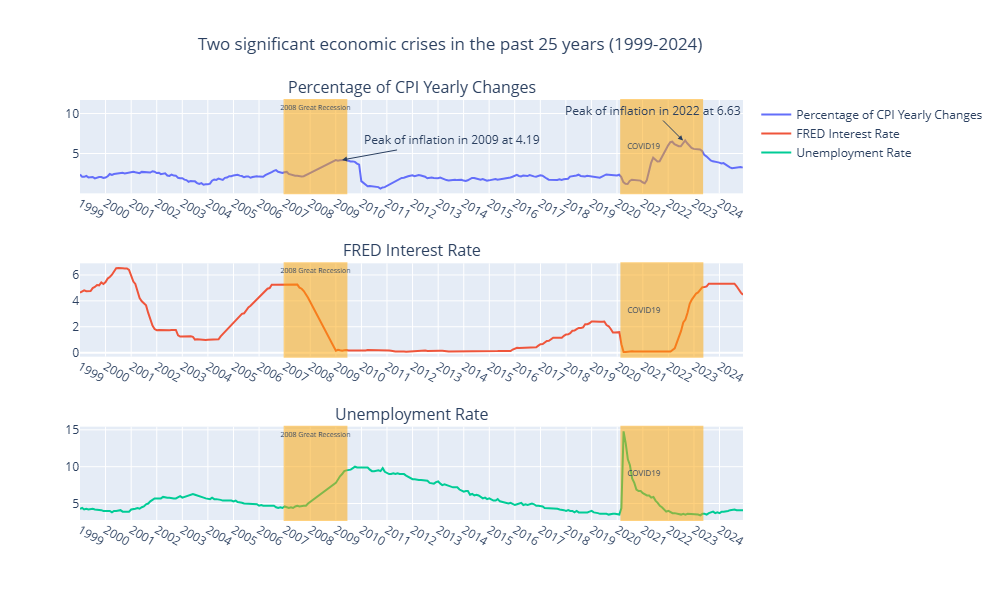

In [9]:
Image("fig1.png")

Figure 1: 25 years of economic data overall between FED interest rate, unemployment, and inflation

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_filtered['date'],
                         y=df_filtered['unemply_rate'],
                         mode='lines',
                         name='Unemployment Rate',
                         line=dict(color='green')))

fig.add_trace(go.Scatter(x=df_filtered['date'],
                         y=df_filtered['FED_rate'],
                         mode='lines',
                         name='FED Rate'))

fig.update_layout(width=1000,
    title="FED's responses to the economic crises (Unemployment rate)",
    yaxis=dict(title="Unemployment and Fed Interest Rate")
)
fig.add_hrect(y0=3,
                  y1=5,
                  fillcolor='orange',
                  line_color='orange',
                  opacity=0.5)
fig.add_annotation(
    x=1.263,
    y=4,
    xref='paper',
    yref='y',
    text='Optimal unemployment rate 3-5%',
    showarrow=False,
    align='left'
)
#Arrow 1
fig.add_annotation(
    x='2008-08', y=2,
    text='FED lowered Interest rate',
    arrowhead=1,
    ax=80,
    ay=25
)

#Arrow 2
fig.add_annotation(
    x='2020', y=1.58,
    text='FED lowered Interest rate',
    arrowhead=1
)

#Arrow 3
fig.add_annotation(
    x='2009-01', y=7.8,
    text='High unemployment rate',
    arrowhead=1,
    ax=-70
)

#Arrow 4
fig.add_annotation(
    x='2020-04', y=14.8,
    text='High unemployment rate',
    arrowhead=1
)

fig.add_annotation(
    text='FED lowers interest rate whenever unemployment rate goes above the optimal area',
    x=0, y=1,
    xref='paper',
    yref='paper',
    showarrow=False,
    xanchor='left',
    yanchor='bottom'
)

fig.show()

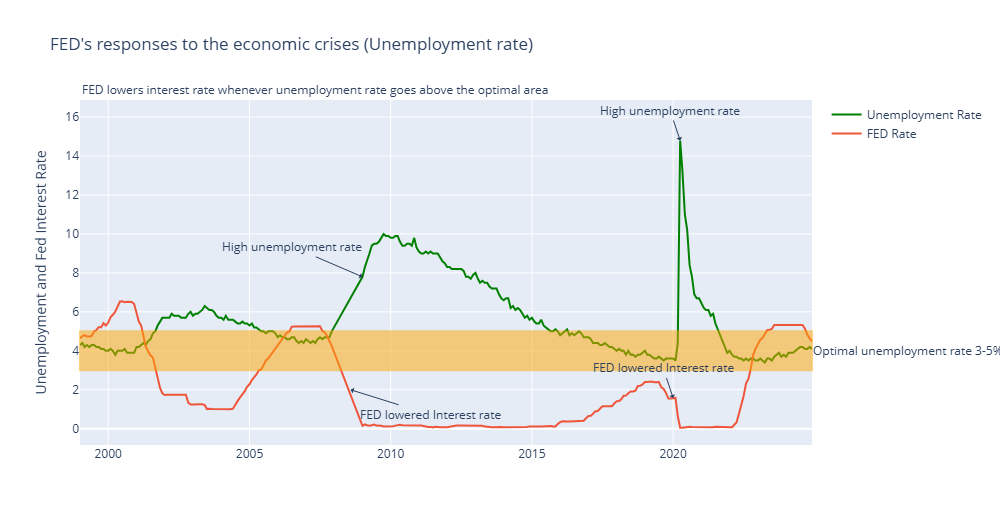

In [11]:
Image("fig2.png")

Figure 2: FED interest rate vs unemployment rate

In [12]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_filtered['date'],
                         y=df_filtered['yearly_cpi_changes'],
                         mode='lines',
                         name='yearly change of CPI'))

fig.add_trace(go.Scatter(x=df_filtered['date'],
                         y=df_filtered['FED_rate'],
                         mode='lines',
                         name='FED Rate'))

fig.update_layout(width=1000,
    title="FED's responses to the economic crises (Inflation-Yearly CPI)",
    yaxis=dict(title="Yearly inflation rate and Fed Interest Rate")
)
fig.add_hline(y=2,
              line_dash='dot')
fig.add_annotation(
    x=1.2,
    y=2,
    xref='paper',
    yref='y',
    text='Optimal inflation rate 2%',
    showarrow=False,
    align='left'
)
fig.update_xaxes(
    dtick='M12',
    tickformat='%Y',
    tickangle=30)

fig.add_annotation(
    x='2008-05', y=3.6,
    text='FED lowered Interest rate to combat umemployment',
    arrowhead=1,
    ax=20,
    ay=-130
)

fig.add_annotation(
    x='2023-03', y=5.06,
    text='FED increased interest rate to control inflation',
    arrowhead=1,
    ax=-160,
    ay=110
)

fig.add_annotation(
    x=0, y=1,
    xref='paper',
    yref='paper',
    showarrow=False,
    text='FED only increases interest rate when inflation deviates from the optimal rate',
    xanchor='left',
    yanchor='bottom'
)

fig.add_annotation(
    x='2021-12', y=5.45,
    text='High Inflation rate during COVID19',
    arrowhead=1,
    ax=-100)

fig.show()




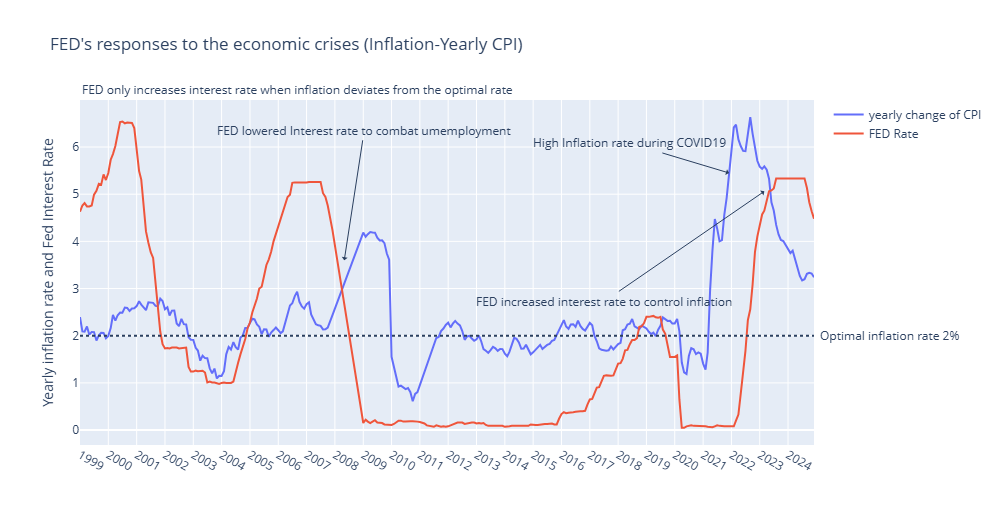

In [13]:
Image("fig3.png")

Figure 3: FED interest rate vs inflation rate (Yearly CPI changes)

In [14]:
df_corr = df_filtered[['FED_rate', 'yearly_cpi_changes', 'unemply_rate']].corr()
fig = px.imshow(df_corr,
          text_auto=True,
          color_continuous_scale='balance',
          zmin=-1, zmax=1,
          aspect="auto"
)
fig.update_layout(width = 700,
                  title='Correlation plot between FED interest, Inflation, and unemployment rate')

fig.add_annotation(
    x=0.2, y=0,
    text='<b>High unemployment rate</b> will make FED to <b>lower interest rate</b>',
    showarrow=True,
    arrowhead=3,
    xref='paper',
    yref='paper',
    ax=80,
    ay=60
)

fig.add_shape(
    type="rect",
    x0=0-0.5, x1=0+0.5,  
    y0=2-0.5, y1=2+0.5,  
    line=dict(color="red", width=3),
    fillcolor="rgba(0,0,0,0)" 
)

# Add an annotation for clarity
fig.add_annotation(
    x=0, y=2.18,
    text="Strong negative link",
    showarrow=False,
    font=dict(color="red", size=12, family="Arial Black")
)


Figure 4: Correlation plots between the three economic factors. There is a stronger inverse relationship link between unemployment rate and FED interest rate than inflation rate.

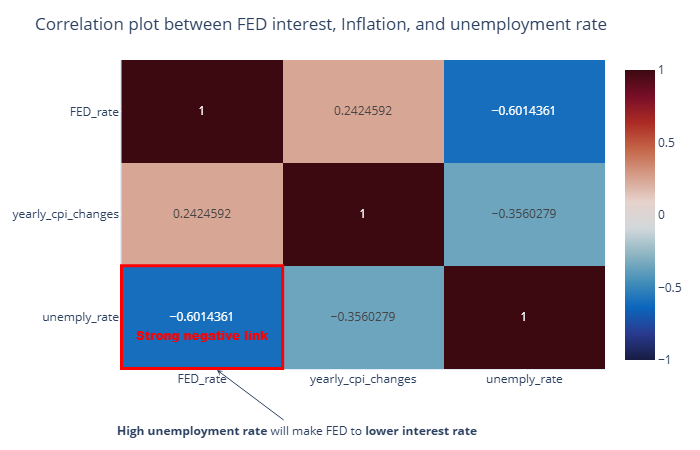

In [18]:
Image("fig5.png")

In [20]:
fig = make_subplots(rows=1,
                    cols = 2,
                    subplot_titles=["Yearly CPI Change", "Unemployment Rate"])

# --------------------------
# Yearly CPI boxplot
fig.add_trace(
    go.Box(y=df_filtered['yearly_cpi_changes'],
           name='Inflation Rate', 
           marker_color='grey',
           boxmean=True),
    row=1, col=1
)

fig.add_hline(y=2, line_dash='dash', line_color='red', row=1, col=1)

fig.add_annotation(
    x=0.5, y=2,
    xref='x domain', yref='y',
    text="Target Inflation Rate: 2%",
    showarrow=True,
    arrowhead=2,
    ax=80, ay=-40,
    row=1, col=1
)

fig.add_annotation(
    x=0.5, y=2.47,
    xref='x domain', yref='y',
    text="Mean Inflation Rate: 2.47%",
    showarrow=True,
    arrowhead=2,
    ax=-80, ay=-40,
    row=1, col=1
)

# --------------------------
# Unemployment boxplot

fig.add_trace(
    go.Box(y=df_filtered['unemply_rate'],
           name='Unemployment Rate',
           marker_color='grey',
           boxmean=True),
    row=1, col=2
)

fig.add_shape(
    type='rect',
    x0=-0.5, x1=0.5,
    y0=3, y1=5,
    line=dict(color='red', dash='dash'),
    fillcolor='red',
    opacity=0.2,
    row=1, col=2
)

fig.add_annotation(
    x=0.9, y=4,
    xref='x domain', yref='y',
    text="Unemployment Target range: 3-5%",
    showarrow=True,
    arrowhead=2,
    ax=100, ay=-40,
    row=1, col=2
)

fig.update_layout(width=800, height=500,
                  title_text="Is FED better at controlling <b>inflation</b> or <b>unemployment?</b>")

fig.add_annotation(
    x=0.5, y=-0.1,
    text='FED controls <b>inflation rate</b> (0.47% from target) better than <b>unemployment rate</b> (0.63% from target range).',
    xref='paper',
    yref='paper',
    showarrow=False,
    xanchor='center',
    yanchor='top',
    font=dict(size=12, color='black')
)

fig.add_annotation(
    x=0.5, y=5.63,
    xref='x domain', yref='y',
    text="Mean Unemployment Rate: 5.63%",
    showarrow=True,
    arrowhead=2,
    ax=100, ay=-40,
    row=1, col=2
)

fig.show()

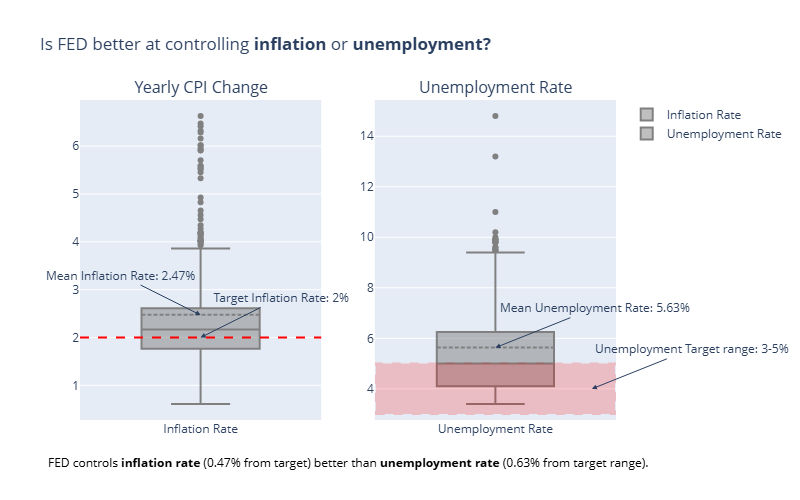

In [21]:
Image("fig4.png")

Figure 5: Average rate distribution between inflation rate and unemployment rate. The average inflation and unemployment rate shows that FED has better control over inflation than unemployment rate. The former is close to the target rate.

### Summary:

Over the past 25 years, two significant economic crises occurred: in 2008 and 2020, marked by a global recession and a global pandemic, respectively. During the 2008 recession, the FED focused on controlling the rapid rise in the unemployment rate by lowering interest rates to historically low levels. Inflation soon fell as high unemployment hindered economic growth. It took almost eight years for the unemployment rate to drop below 5%, reaching that level in 2016.

During the COVID-19 pandemic, unemployment surged to a historical high, and the FED implemented similar measures to stabilize the economy by lowering interest rates. However, this action eventually contributed to an inflation surge in 2023, prompting the FED to raise rates to control inflation.

Based on these historical events, the FED appears to have more control over inflation than unemployment, as shown in Figures 5, where inflation more consistently revolves around the target rate compared to unemployment. Additionally, the FED seems to respond more sensitively to rises in unemployment, as shown in Figure 2. Their strategy of increasing interest rates when inflation is high and decreasing rates when unemployment is high appears to be more effective in controlling inflation. Unemployment, however, is a more complex system that does not respond solely to interest rate adjustments.

Overall, the FED has been relatively successful in achieving its goals of bringing inflation and unemployment closer to their target levels.